In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
key = jax.random.PRNGKey(0)

In [3]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

In [4]:
dist = 2.1095

R = jnp.array([[dist/2,0,0],[-dist/2,0,0]])     # nuclei positions
k = jnp.array([1.,1.])                          # potential energy coefficients (nuclear charge)

In [5]:
def calc_E_nuc():
    acc = 0
    for i in range(len(R)):
        for j in range(i + 1, len(R)):
            d = jnp.sqrt(jnp.sum((R[i] - R[j])**2))
            acc += k[i] * k[j] / d


    return acc

E_nuc = calc_E_nuc()

In [6]:
#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    x = jnp.expand_dims(x, axis = 1)
    r = jnp.expand_dims(R,  axis = 0)
    d = jnp.sqrt(jnp.sum((x - r)**2, axis = 2))
    return - jnp.sum(k/d ,axis = 1) + E_nuc


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)


In [68]:
# def h(x):
#     return 0.5*jnp.where(x < -1, -1, jnp.where(x < 1, 15/8*x -5/4*x**3 + 3/8*x**5 , 1)) + 0.5

def h(x):
    return 0.5*jnp.where(x < -1, -1, jnp.where(x < 1,  2.1875*x+  -2.1875*x**3+  1.3125*x**5+ -0.3125*x**7  , 1)) +0.5

class LCAO(module.wavefunctions.Wavefunction):
    def __init__(self, d_space = 3):
        """
        Creates a LCAO orbital in dimensions d.
        """
        super().__init__(input_shape = (d_space,))

        self.r_0 = 0.1
        self.eps = 0.9


    def init_param(self, R, k, lamb):
        """
        Creates the parameter pytree which incorporates shape R = (N_nuclei, d) positions of nuclei,
        shape k = (N_nuclei) potential energy coefficients and shape l = (N_nuclei) linear combination coefficients.
        """
        return {"R": R, "k": k, "lamb": lamb}


    def calc_logpsi(self, parameters, x):
        """
        Evaluates the logarithm of psi at positions shape x = (N_samples, d). The parameters incorporate the scaling
        coefficients for the linear combination of orbitals, and thus have shape = (N_nuclei,).
        """
        x = jnp.expand_dims(x, axis = 1)
        R = jnp.expand_dims(parameters["R"], axis = 0)

        d = jnp.sqrt(jnp.sum((x - R)**2, axis = -1))

        cut = jnp.expand_dims(h((d - self.r_0 - self.eps)/self.eps), axis = -1)

        id = jnp.expand_dims(jnp.diag(jnp.ones(R.shape[1])), axis = 0)
        
        prefac = cut * (1 - id) + id
        fac = jnp.flip(jnp.prod(cut, axis = -1),axis = -1)

        # return -parameters["k"] * d + jnp.log(parameters["lamb"] * fac), fac, cut, prefac, id
        return jax.scipy.special.logsumexp(-parameters["k"] * d, b = parameters["lamb"] * fac, axis = -1)

In [69]:
ansatz_LCAO = module.wavefunctions.LCAO()
p1 = ansatz_LCAO.init_param(R, k, jnp.array([1.,1.]))
ansatz_LCAO_cutoff = LCAO()
p2 = ansatz_LCAO_cutoff.init_param(R, k, jnp.array([1.,1.]))

Text(0, 0.5, '$\\Psi$')

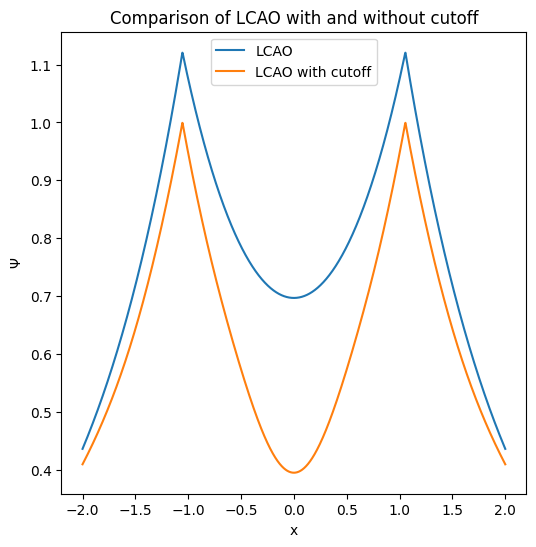

In [76]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz_LCAO.calc_psi(p1, line)
psi2 = ansatz_LCAO_cutoff.calc_psi(p2, line)

plt.plot(r, psi, label = "LCAO")
plt.plot(r, psi2, label = "LCAO with cutoff")


plt.title("Comparison of LCAO with and without cutoff")
plt.legend()
plt.xlabel("x")
plt.ylabel("$\\Psi$")

Text(0.5, 0, 'x')

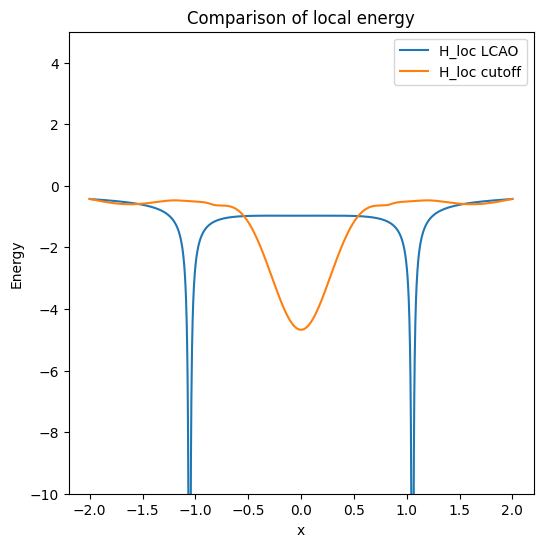

In [77]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=2)


H_loc = hamiltonian.calc_H_loc(ansatz_LCAO, p1, line)
H_loc_cutoff = hamiltonian.calc_H_loc(ansatz_LCAO_cutoff, p2, line)



plt.plot(r, H_loc, label = "H_loc LCAO")
plt.plot(r, H_loc_cutoff, label = "H_loc cutoff")

plt.ylim(-10, 5)

plt.title("Comparison of local energy")
plt.legend()
plt.ylabel("Energy")
plt.xlabel("x")

Using an LCAO Ansatz:
$$
\Psi = e^{-r} + e^{-|r - R|}
$$

results in a diverging energy density:

$$
H_{loc} = \frac{1}{r}e^{-|r - R|} + ...
$$

In [92]:
N = 10000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
E_f = jnp.mean(H_loc)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Energy Error:", (jnp.mean(H_loc) + 0.616515)/0.616515)
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.51044
Expected Energy: -0.6022925825923029 +/- 0.00045635486039633736
Energy Error: 0.023069053320190328
Std of Expected Energy: 0.04563548603963374


In [22]:
27.2114 * 0.0249436 * 0.616515
# eV

0.4184597270493156